In [465]:
import requests
import numpy as np
import pandas as pd
import pymongo

from pymongo import MongoClient
import time
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [208]:
from IPython.display import clear_output
import time

#some cells take a long time to run, add progress bar to those cells
def update_progress(progress):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

# Import Chess.com Data

In [2]:
#delcare client and chess database
client = MongoClient()
chess_db = client['chess_db']
players = chess_db['players']

In [3]:
# #import player names json data from Emissions API: https://emissions-api.org/
# response = requests.get('https://api.chess.com/pub/streamers')
# players.insert_many(response.json()['streamers']);

In [4]:
#query and make list of all usernames 
usernames = [ i['username'] for i in list(players.find({},{'_id':0,'username':1}))]

#the code below is commented out because the dataset has already been collected

# #go through all usernames and get archive collections
# for name in usernames:
#     response = requests.get('https://api.chess.com/pub/player/'+name+'/games/archives')
#     chess_db['archives'].insert_one({'username':name, 'data':response.json()['archives']});

In [5]:
#the code below is commented out because the dataset has already been collected

# #go through all usernames and get user stats
# for name in usernames[211:212]:
#     response = requests.get('https://api.chess.com/pub/player/'+name+'/stats')
#     chess_db['stats'].insert_one({'username':name, 'data':response.json()});

In [6]:
#the code below is commented out because the dataset has already been collected

#find all archive links for all players
archive_links = [ i['data'] for i in list(chess_db.archives.find({},{'_id':0,'data':1}))]
archive_links = sum(archive_links,[]) #find function above returns nested lists, combine into one list

# #go through all archive pages and download game data
# error_list=[]
# for i, link in enumerate(archive_links[11249:]):
#     response = requests.get(link)
#     try:
#         chess_db['games'].insert_many(response.json()['games']);
#     except KeyError: #some archives may be empty, track and ignore
#         error_list.append(f"Archive link {link} was empty")
#     tracker = i
# print(tracker)

# Query Game Stats 

In [124]:
#pipeline to gather all game data for a set of players
games = ['chess_daily','chess960_daily','chess_rapid','chess_bullet','chess_blitz']
stats_df = pd.DataFrame()

#function for query call, as to not save intermediate dataframes
def query_stats(game, in_list = usernames):
    pipeline = [
            {'$match':{'username':{'$in':in_list}}},
            {'$project': {'_id':0, 'username':1,'game':game,
                          'last_rating':'$data.'+game+'.last.rating',
                          'last_date':'$data.'+game+'.last.date',
                          'best_rating':'$data.'+game+'.best.rating',
                          'best_date':'$data.'+game+'.best.date',
                          'wins':'$data.'+game+'.record.win',
                          'draw':'$data.'+game+'.record.draw',
                          'loss':'$data.'+game+'.record.loss',
                          'time_per_move':'$data.'+game+'.record.time_per_move'
                         }}, 
        ]
    return pd.DataFrame(chess_db.stats.aggregate(pipeline))

for game in games:
    stats_df = pd.concat([stats_df,query_stats(game)],ignore_index =True)

#sanity check
stats_df

,username,game,last_rating,last_date,best_rating,best_date,wins,draw,loss,time_per_move
0,Hikaru,chess_daily,2239.0,1.466716e+09,2464.0,1.397137e+09,73.0,4.0,11.0,24338.0
1,Blitzstream,chess_daily,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,annacramling,chess_daily,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SvyatoslavKorneev,chess_daily,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CCCC,chess_daily,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1705,Hyundong_Yoo,chess_blitz,1010.0,1.597496e+09,1308.0,1.594296e+09,139.0,8.0,174.0,NaN
1706,rodp92,chess_blitz,2567.0,1.622994e+09,2582.0,1.607468e+09,1729.0,174.0,1165.0,NaN
1707,TigerLilov,chess_blitz,2531.0,1.588590e+09,2708.0,1.564327e+09,339.0,29.0,231.0,NaN
1708,tjallkompall,chess_blitz,2728.0,1.634912e+09,2806.0,1.577660e+09,683.0,111.0,627.0,NaN


              username  last_rating
94    GMHikaruOnTwitch  3089.000000
314         nihalsarin  3005.666667
33           ChessBrah  2999.666667
19          Azerichess  2938.333333
336         viditchess  2929.666667
..                 ...          ...
269       chuckmoulton          NaN
280       gothamchess2          NaN
281       gothamchess4          NaN
282       gothamchess6          NaN
328  suprhotdogsTWITCH          NaN

[342 rows x 2 columns]
AxesSubplot(0.125,0.125;0.775x0.755)


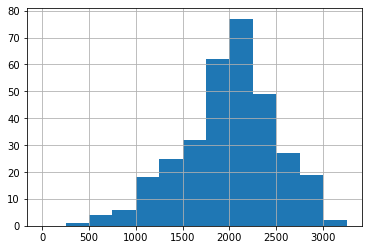

In [8]:
avg_ratings = stats_df.groupby(by = 'username', as_index = False)['last_rating'].mean().sort_values(by='last_rating', ascending =False)
print(avg_ratings)
bins = [0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250]
print(avg_ratings.last_rating.hist(bins = bins))

In [9]:
streamer_list = []
bins = [(0,750),(750,1000),(1000,1250),(1250,1500),(1500,1750),(1750,2000),(2000,2250),(2250,2500),
        (2500,2750),(2750,3100)]
for i,j in bins: 
    mask = (avg_ratings.last_rating > i) & (avg_ratings.last_rating < j)
    streamer_list.append(list(avg_ratings[mask].username.sample(3)))
streamer_list = sum(streamer_list,[])
streamer_list

['MichelleKhare',
 'QTCinderella',
 'jppeixoto29',
 'Sheemiee',
 'Polype83',
 'Hyundong_Yoo',
 'AioStream',
 'shadowc',
 'choptochop',
 'ChessKid',
 'MikeySlice',
 'ChesscomChris',
 'shaun',
 'TaylorCHall',
 'chesscomDE',
 'nicecream18',
 'LETSCHESSLIVE',
 'th3d4rkness',
 'monstertube',
 'zibbit',
 'josiwales',
 'Th3_Hound',
 'ahappypawn',
 'mironius',
 'EvgenyT',
 'ckgchess',
 'SenseiJulio',
 'Azerichess',
 'Avetik_ChessMood',
 'Fandorine']

# Pick Selection of Streamers and Get Game Data

In [10]:
#pipeline to gather all game data for a set of players
games_df = pd.DataFrame()
for username in streamer_list:
    pipeline = [
        {'$match':{'$or':[{'white.username':username},{'black.username':username}]}},
        {'$sample': {'size':1000}},
        {'$project': {'_id':0, 'time_control':1,'initial_setup':1,'fen':1,'time_class':1,'rules':1,'rated':1,
                      'white_name':'$white.username','white_rating':'$white.rating','white_accuracy':'$accuracies.white',
                      'white_result':'$white.result','black_name':'$black.username','black_rating':'$black.rating',
                      'black_accuracy':'$accuracies.black','black_result':'$black.result'}}, 
    ]
    games_df = pd.concat([games_df,pd.DataFrame(chess_db.games.aggregate(pipeline))],ignore_index=True)
games_df.head()

,time_control,rated,initial_setup,fen,time_class,rules,white_name,white_rating,white_result,black_name,black_rating,black_result,white_accuracy,black_accuracy
0,600,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...,rapid,chess,legend2307,1119,resigned,MichelleKhare,909,win,NaN,NaN
1,600,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,3q1k2/3n1QbR/1r4p1/p5N1/8/8/P4PPP/6K1 b - -,rapid,chess,elofenio,407,win,MichelleKhare,427,checkmated,18.22,10.28
2,600,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,3r4/pp6/7p/1k5N/2R1P3/P4P2/nP2B1PP/1R4K1 w - -,rapid,chess,MichelleKhare,526,timeout,Hansika7244,585,win,57.95,22.03
3,600,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,5Q2/1b3R1k/1p4pp/1p6/P1p3P1/1P6/2r3P1/7K b - -,rapid,chess,dhssmiley,564,win,MichelleKhare,593,checkmated,56.97,25.61
4,300,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1r1qr1kB/3pnpQp/2p1p1p1/8/BP2P3/8/P4PPP/5bK1 b...,blitz,chess,Quaglon,935,win,MichelleKhare,496,checkmated,43.56,35.96


#### Convert Target to win/loss/draw

In [12]:
#Many different draw and loss scenarios, convert all to draw and loss for simplicity 
games_df.loc[(games_df['white_result'] == 'win') & (games_df['black_result'] != 'win'), 'black_result'] = 'loss'
games_df.loc[(games_df['white_result'] != 'win') & (games_df['black_result'] == 'win'), 'white_result'] = 'loss'
games_df.loc[games_df['white_result'] == games_df['black_result'], ['black_result','white_result']] = 'draw'

In [14]:
#sanity check
print(games_df.white_result.unique())
print(f"There are {len(games_df)} observations.")
np.sum(games_df.black_result == 'win') + np.sum(games_df.white_result == 'win')+ np.sum(games_df.black_result == 'draw')

['loss' 'win' 'draw']
There are 24929 observations.


24929

#### Pipeline to find stats for white and black players

In [86]:
white_usernames = list(games_df.white_name.unique())
black_usernames = list(games_df.black_name.unique())
game_usernames = list(set(white_usernames+black_usernames))
len(game_usernames)

15041

In [211]:
#chess_db['white_black_stats'].delete_many({},{}); #need this to be cleared with each new game sample
#go through all usernames and get user stats
array_len = len(game_usernames)
for i, name in enumerate(game_usernames[13200:]):
    response = requests.get('https://api.chess.com/pub/player/'+name+'/stats')
    chess_db['stats'].update_one({'username':name},{'$set':{'username':name,'data':response.json()}},upsert=True);
    update_progress((i+1)/len(game_usernames[13200:]))

Progress [##################################################] 100.0%


In [212]:
#query new stats
white_stats_df = pd.DataFrame()
black_stats_df = pd.DataFrame()
for game in games:
    white_stats_df = pd.concat([white_stats_df,query_stats(game, in_list=white_usernames)],ignore_index =True)
    black_stats_df = pd.concat([black_stats_df,query_stats(game, in_list=black_usernames)],ignore_index =True)

In [213]:
#training data for a set of players
def query_lessons(in_list = None, player='white'):
    pipeline = [
        {'$match':{'username':{'$in':in_list}}},
        {'$project': {'_id':0, 'username':1,
                      (player+'_tactic_rating_low'):'$data.tactics.lowest.rating',
                      (player+'_tactic_rating_low_date'):'$data.tactics.lowest.date',
                      (player+'_tactic_rating_high'):'$data.tactics.highest.rating',
                      (player+'_tactic_rating_high_date'):'$data.tactics.highest.date',
                      (player+'_lesson_rating_low'):'$data.lessons.lowest.rating',
                      (player+'_lessons_rating_low_date'):'$data.lessons.lowest.date',
                      (player+'_lesson_rating_high'):'$data.lessons.highest.rating',
                      (player+'_lesson_rating_high_date'):'$data.lessons.highest.date',
                      (player+'_puzzle_best_attempts'):'$data.puzzle_rush.best.total_attempts',
                      (player+'_puzzle_best_score'):'$data.puzzle_rush.best.score',
                      (player+'_puzzle_daily_attempts'):'$data.puzzle_rush.daily.total_attempts',
                      (player+'_puzzle_daily_score'):'$data.puzzle_rush.daily.score'
                     }}
    ]
    return pd.DataFrame(chess_db.stats.aggregate(pipeline))

In [214]:
white_lessons_df = query_lessons(white_usernames, player='white')
black_lessons_df = query_lessons(black_usernames, player='black')

#### Merge all Dataframes

In [215]:
white_df = pd.merge(white_stats_df, white_lessons_df, on='username')
black_df = pd.merge(black_stats_df, black_lessons_df, on='username')
white_df

,username,game,last_rating,last_date,best_rating,best_date,wins,draw,loss,time_per_move,...,white_tactic_rating_high,white_tactic_rating_high_date,white_puzzle_best_attempts,white_puzzle_best_score,white_puzzle_daily_attempts,white_puzzle_daily_score,white_lesson_rating_low,white_lessons_rating_low_date,white_lesson_rating_high,white_lesson_rating_high_date
0,Hikaru,chess_daily,2239.0,1.466716e+09,2464.0,1.397137e+09,73.0,4.0,11.0,24338.0,...,3421.0,1.539085e+09,120.0,117.0,62.0,59.0,NaN,NaN,NaN,NaN
1,Hikaru,chess960_daily,1231.0,1.444458e+09,1489.0,1.397073e+09,1.0,0.0,2.0,24338.0,...,3421.0,1.539085e+09,120.0,117.0,62.0,59.0,NaN,NaN,NaN,NaN
2,Hikaru,chess_rapid,2740.0,1.634403e+09,2829.0,1.588687e+09,13.0,2.0,2.0,NaN,...,3421.0,1.539085e+09,120.0,117.0,62.0,59.0,NaN,NaN,NaN,NaN
3,Hikaru,chess_bullet,3414.0,1.634853e+09,3570.0,1.605136e+09,9935.0,551.0,1329.0,NaN,...,3421.0,1.539085e+09,120.0,117.0,62.0,59.0,NaN,NaN,NaN,NaN
4,Hikaru,chess_blitz,3229.0,1.635279e+09,3332.0,1.585690e+09,19934.0,2563.0,3540.0,NaN,...,3421.0,1.539085e+09,120.0,117.0,62.0,59.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42430,ertakay10,chess_daily,724.0,1.622876e+09,1259.0,1.620718e+09,2.0,0.0,6.0,57558.0,...,2105.0,1.635066e+09,54.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN
42431,ertakay10,chess960_daily,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2105.0,1.635066e+09,54.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN
42432,ertakay10,chess_rapid,1509.0,1.633518e+09,1509.0,1.619550e+09,3.0,1.0,0.0,NaN,...,2105.0,1.635066e+09,54.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN
42433,ertakay10,chess_bullet,2816.0,1.635338e+09,2878.0,1.629475e+09,683.0,112.0,616.0,NaN,...,2105.0,1.635066e+09,54.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
#add new columns to allow merging on games_df
white_df.rename(columns={'username':'white_name'},inplace=True)
black_df.rename(columns={'username':'black_name'},inplace=True)
games_df['game'] = 'chess_'+games_df.time_class

In [970]:
#merge once each for white and black players
final_df = pd.merge(games_df, white_df, how='left',on=['white_name','game'])
final_df = pd.merge(final_df, black_df,how='left', on=['black_name','game'])
final_df

,time_control,rated,initial_setup,fen,time_class,rules,white_name,white_rating,white_result,black_name,...,black_tactic_rating_high,black_tactic_rating_high_date,black_puzzle_best_attempts,black_puzzle_best_score,black_puzzle_daily_attempts,black_puzzle_daily_score,black_lesson_rating_low,black_lessons_rating_low_date,black_lesson_rating_high,black_lesson_rating_high_date
0,600,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...,rapid,chess,legend2307,1119,loss,MichelleKhare,...,1518.0,1.628442e+09,17.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
1,600,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,3q1k2/3n1QbR/1r4p1/p5N1/8/8/P4PPP/6K1 b - -,rapid,chess,elofenio,407,win,MichelleKhare,...,1518.0,1.628442e+09,17.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,600,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,3r4/pp6/7p/1k5N/2R1P3/P4P2/nP2B1PP/1R4K1 w - -,rapid,chess,MichelleKhare,526,loss,Hansika7244,...,1022.0,1.634569e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,600,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,5Q2/1b3R1k/1p4pp/1p6/P1p3P1/1P6/2r3P1/7K b - -,rapid,chess,dhssmiley,564,win,MichelleKhare,...,1518.0,1.628442e+09,17.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
4,300,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,1r1qr1kB/3pnpQp/2p1p1p1/8/BP2P3/8/P4PPP/5bK1 b...,blitz,chess,Quaglon,935,win,MichelleKhare,...,1518.0,1.628442e+09,17.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24924,180+1,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,5k2/5Q2/p3K1P1/2b5/1p6/P7/1P6/8 b - -,blitz,chess,Fandorine,2819,win,AttilaTurzo,...,2769.0,1.502197e+09,48.0,45.0,NaN,NaN,1532.0,1.238756e+09,2009.0,1.543135e+09
24925,3600+5,False,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,4R3/8/8/5K2/r7/3k4/5p2/8 w - -,rapid,chess,ChessicallyInclined,2004,loss,Fandorine,...,4188.0,1.585664e+09,70.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN
24926,180,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,3q1rk1/prnnppbp/1p1p2p1/1NpP4/P3PB2/2N5/1PP1QP...,blitz,chess,MITerryble,2940,draw,Fandorine,...,4188.0,1.585664e+09,70.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN
24927,180+2,True,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,6k1/1Q6/3p3p/2pPp3/2P1N2P/4n1P1/8/5qK1 w - -,blitz,chess,MITerryble,2634,loss,Fandorine,...,4188.0,1.585664e+09,70.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN


# Clean Data

In [971]:
#check for nulls
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24929 entries, 0 to 24928
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   time_control                   24929 non-null  object 
 1   rated                          24929 non-null  bool   
 2   initial_setup                  24929 non-null  object 
 3   fen                            24929 non-null  object 
 4   time_class                     24929 non-null  object 
 5   rules                          24929 non-null  object 
 6   white_name                     24929 non-null  object 
 7   white_rating                   24929 non-null  int64  
 8   white_result                   24929 non-null  object 
 9   black_name                     24929 non-null  object 
 10  black_rating                   24929 non-null  int64  
 11  black_result                   24929 non-null  object 
 12  white_accuracy                 6139 non-null  

In [972]:
#fill in applicable nulls with 0 for unattempted games/puzzles etc
#not filling in rating info, chosing not to make assumptions on rating
mask = ['white_tactic_rating_low_date',
       'white_tactic_rating_high_date',
       'white_puzzle_best_attempts', 'white_puzzle_best_score',
       'white_puzzle_daily_attempts', 'white_puzzle_daily_score',
       'white_lessons_rating_low_date',
       'white_lesson_rating_high_date',
        'black_tactic_rating_low_date',
       'black_tactic_rating_high_date',
       'black_puzzle_best_attempts', 'black_puzzle_best_score',
       'black_puzzle_daily_attempts', 'black_puzzle_daily_score',
        'black_lessons_rating_low_date',
       'black_lesson_rating_high_date',
       'wins_x', 'draw_x', 'loss_x','wins_y', 'draw_y', 'loss_y',]
final_df.loc[:,mask] = final_df.loc[:,mask].fillna(value=0)

mask = ['white_tactic_rating_low', 'white_tactic_rating_high', 
               'white_lesson_rating_low', 'white_lesson_rating_high', 
               'black_tactic_rating_low','black_tactic_rating_high', 
               'black_lesson_rating_low', 'black_lesson_rating_high',
        'last_rating_y', 'best_rating_y','last_rating_x', 'best_rating_x',
       ]
final_df.loc[:,mask] = final_df.loc[:,mask].fillna(value=1200)

In [973]:
#convert epoch time to %Y%m%d %H%M%s
date_mask = ['last_date_x','best_date_x', 'white_tactic_rating_low_date',
       'white_tactic_rating_high_date','white_lessons_rating_low_date',
       'white_lesson_rating_high_date','last_date_y', 'best_date_y',
       'black_tactic_rating_low_date','black_tactic_rating_high_date',
       'black_lessons_rating_low_date', 'black_lesson_rating_high_date', ]
for col in date_mask:
    final_df[col] = pd.to_datetime(final_df[col],unit = 's')

# Initial Feature Engineering

In [974]:
#drop 4 unused columns
#time_per_move had too few observations
#accuracy is only known after game, use pre game features only
final_df.drop(labels=['time_per_move_x','time_per_move_y','white_accuracy','black_accuracy'],axis=1, inplace=True)

In [975]:
#a few nulls left, drop them
final_df.dropna(inplace=True)

# Make Baseline Model

In [241]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, fbeta_score, confusion_matrix

In [724]:
#pull basic model parameters
X = final_df[['white_rating','black_rating']]
y = final_df['white_result']

In [725]:
#map classes to integers so xgboost can be used
y =y.map({'draw':2,'win':1,'loss':0})
X = X[y!=2]
y = y[y!=2]

In [726]:
#create training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [727]:
def quick_grid_CV(model, param_grid,X,y):
    grid = GridSearchCV(model, param_grid, cv=5)
    grid.fit(X, y);
    print("Best params: ", grid.best_params_)
    print("Best estimator: ", grid.best_estimator_)
    print("Best score: ", grid.best_score_)
    print("Val score: ",accuracy_score(y_val, grid.predict(X_val)))
    print("F1 score: ",f1_score(y_val, grid.predict(X_val),average='weighted'))
    sns.heatmap(confusion_matrix(y_val, grid.predict(X_val)),annot=True,fmt='g', 
               xticklabels=['loss','win'], yticklabels=['loss','win'])
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f"{grid.best_estimator_} Confusion Matrix")

Best params:  {'n_estimators': 81}
Best estimator:  RandomForestClassifier(n_estimators=81)
Best score:  0.6640468566294424
Val score:  0.6651047409040793
F1 score:  0.6649448503524718


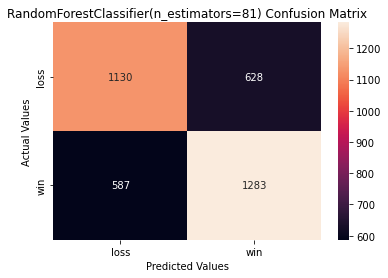

In [728]:
#Random Forest
randomforest = RandomForestClassifier(n_estimators=100)
estimators_range = list(range(1, 110,20))
param_grid = dict(n_estimators=estimators_range)
quick_grid_CV(randomforest,param_grid,X_train,y_train)

Best params:  {'max_depth': 12}
Best estimator:  DecisionTreeClassifier(max_depth=12)
Best score:  0.6555004797651705
Val score:  0.6598676957001103
F1 score:  0.659903175767556


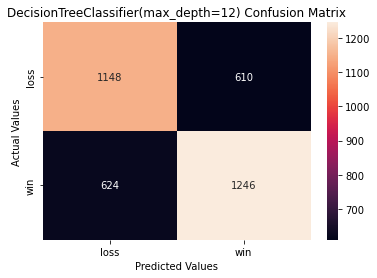

In [729]:
#Decision Tree
decisiontree = DecisionTreeClassifier(max_depth=4)
estimators_range = list(range(1, 15,1))
param_grid = dict(max_depth=estimators_range)
quick_grid_CV(decisiontree,param_grid,X_train,y_train)

Best params:  {'C': 0.01}
Best estimator:  LogisticRegression(C=0.01)
Best score:  0.7044393779468615
Val score:  0.7036934950385888
F1 score:  0.7017871749574375


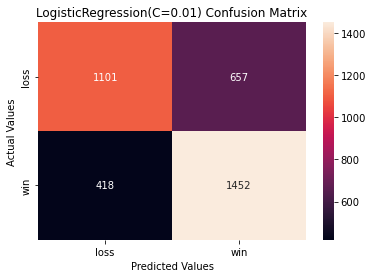

In [730]:
#logistic
logreg = LogisticRegression() #solver='liblinear')
estimators_range = np.linspace(.01,2.0,20)
param_grid = dict(C=estimators_range)
quick_grid_CV(logreg,param_grid,X_train,y_train)

Best params:  {'n_neighbors': 46}
Best estimator:  KNeighborsClassifier(n_neighbors=46)
Best score:  0.6996144773861813
Val score:  0.697353914002205
F1 score:  0.6973773856777793


/Users/bats/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/bats/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Users/bats/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


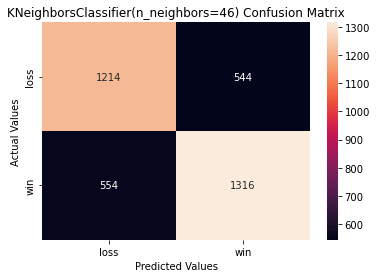

In [731]:
#knn
knn = KNeighborsClassifier(n_neighbors=5)
k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range)
quick_grid_CV(knn,param_grid,X_train.values,y_train)

In [702]:
#xgboost
gbm = xgb.XGBRegressor( 
                       n_estimators=3000, #arbitrary large number
                       max_depth=6,
                       objective='binary:hinge',  # Other options: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
                       #num_class=3,
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8,
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='auc',
                    early_stopping_rounds=20,
                    verbose=False, #gives output log as below
                   )

In [703]:
print(accuracy_score(y_val, fit_model.predict(X_val,ntree_limit=gbm.best_ntree_limit)))
print(f1_score(y_val, fit_model.predict(X_val)))

0.5832414553472988
0.6477166821994409


/Users/bats/opt/anaconda3/envs/metis/lib/python3.9/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

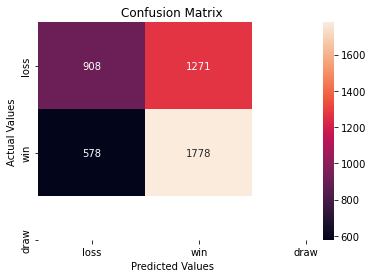

In [704]:
sns.heatmap(confusion_matrix(y_test, gbm.predict(X_test)),annot=True,fmt='g', 
               xticklabels=['loss','win','draw'], yticklabels=['loss','win','draw'])
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title(f"Confusion Matrix")

# Correct Class Imbalance and Refit with KNN model
note: this was aborted after too much difficultly predicting the rare target 'draw'

In [690]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
n_draw = np.sum(y_train == 2)
n_win = np.sum(y_train == 1)
n_loss = np.sum(y_train == 0)
ratio = {2 : n_draw * 4,1:n_win, 0 : n_loss} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

Best params:  {'n_estimators': 40}
Best estimator:  RandomForestClassifier(n_estimators=40)
Best score:  0.7000965477438227
Val score:  0.5914587085155647
F1 score:  0.5888277926395955


Text(0.5, 1.0, 'RandomForestClassifier(n_estimators=40) Confusion Matrix')

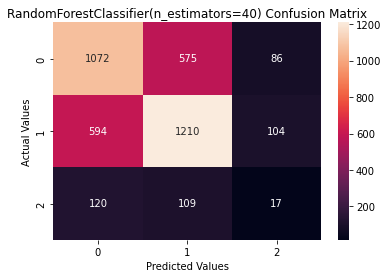

In [692]:
# #knn
# knn = KNeighborsClassifier(n_neighbors=5)
# k_range = list(range(1, 100))
# weight_options = ['uniform', 'distance']
# leaf_size = list(range(5,50,5))
# param_grid = dict(n_neighbors=k_range,weights=weight_options, leaf_size=leaf_size )

#Random Forest
randomforest = RandomForestClassifier(n_estimators=100)#,class_weight ={2:n_draw * 5,1:n_win, 0 : n_loss} )
estimators_range = list(range(10, 110,10))
param_grid = dict(n_estimators=estimators_range)

# #logistic
# logreg = LogisticRegression()#solver='liblinear')
# estimators_range = np.linspace(.0001,2.0,100)
# param_grid = dict(C=estimators_range, multi_class=('auto', 'ovr', 'multinomial'))

grid = GridSearchCV(randomforest, param_grid)
grid.fit(X_train_rs.values, y_train_rs.values);
print("Best params: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)
print("Best score: ", grid.best_score_)
print("Val score: ",accuracy_score(y_val, grid.predict(X_val.values)))
print("F1 score: ",f1_score(y_val, grid.predict(X_val.values),average='weighted'))

sns.heatmap(confusion_matrix(y_val, grid.predict(X_val.values)),annot=True,fmt='g', 
           xticklabels=grid.classes_, yticklabels=grid.classes_)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title(f"{grid.best_estimator_} Confusion Matrix")

# Add In Extra Features

In [628]:
import datetime as dt

In [1008]:
final_df['white_win_perc'] = final_df.wins_x / (final_df.wins_x+final_df.loss_x+final_df.draw_x)
final_df['black_win_perc'] = final_df.wins_y / (final_df.wins_y+final_df.loss_y+final_df.draw_y)
final_df['white_days_since_best_rating'] = (final_df.last_date_x - final_df.best_date_x).dt.days
final_df['black_days_since_best_rating'] = (final_df.last_date_y - final_df.best_date_y).dt.days
final_df['white_frac_of_best_rating'] = final_df.white_rating/final_df.best_rating_x
final_df['black_frac_of_best_rating'] = final_df.black_rating/final_df.best_rating_y
final_df['white_frac_of_last_rating'] = final_df.last_rating_x/final_df.best_rating_x
final_df['black_frac_of_last_rating'] = final_df.last_rating_y/final_df.best_rating_y

In [1064]:
# generate new X
# if feature commented out, it was determined not to improve the model
mask = [#'rated','rules','game',
        'white_rating', 'black_rating', 
       'last_rating_x','best_rating_x', 
        # 'wins_x', 'draw_x', 'loss_x',
        # 'white_tactic_rating_low','white_tactic_rating_high', 
       'white_puzzle_best_attempts', 'white_puzzle_best_score',
       'white_puzzle_daily_attempts', 'white_puzzle_daily_score',
       # 'white_lesson_rating_low','white_lesson_rating_high',
       'last_rating_y', 'best_rating_y',
        # 'wins_y', 'draw_y', 'loss_y',
        # 'black_tactic_rating_low','black_tactic_rating_high',
       'black_puzzle_best_attempts','black_puzzle_best_score',
        'black_puzzle_daily_attempts','black_puzzle_daily_score', 
        # 'black_lesson_rating_low','black_lesson_rating_high',
        'white_win_perc','black_win_perc',
         'white_days_since_best_rating','black_days_since_best_rating',
        'white_frac_of_best_rating','black_frac_of_best_rating',
        'white_frac_of_last_rating','black_frac_of_last_rating'
]
X = final_df[mask]
y = final_df['white_result']
#add categorical variables
# categorical variables removed because they were not useful in model
#X = pd.get_dummies(X , columns=['rated','game','rules'])

In [1065]:
#map classes to integers so xgboost can be used
y =y.map({'draw':2,'win':1,'loss':0})
X = X[y!=2]
y = y[y!=2]

In [1066]:
#create training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [1067]:
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

0.7003032809484422
0.6959757442116868
0.7111809374181722


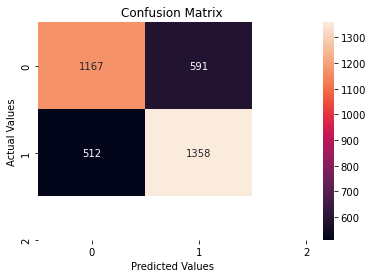

In [1068]:
#logistic
# logreg = LogisticRegression(solver='liblinear')
# estimators_range = np.linspace(.01,50.0,20)
# param_grid = dict(C=estimators_range)
# quick_grid_CV(logreg,param_grid,X_train_scaled,y_train)

logreg = LogisticRegression(C = 18.5, solver='liblinear')
logreg.fit(X_train_scaled,y_train)
print(logreg.score(X_train_scaled,y_train))
print(logreg.score(X_val_scaled,y_val))
print(f1_score(y_val,logreg.predict(X_val_scaled)))

sns.heatmap(confusion_matrix(y_val, logreg.predict(X_val_scaled)),annot=True,fmt='g', 
               xticklabels=grid.classes_, yticklabels=grid.classes_)
plt.xlabel('Predicted Values');
plt.ylabel('Actual Values');
plt.title(f"Confusion Matrix");

# Get Final Metrics 

Accuracy:  0.6972436604189636
F1 score:  0.7305201177625122


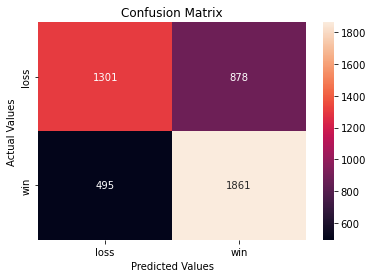

In [1069]:
#final metrics
print('Accuracy: ',accuracy_score(y_test, logreg.predict(X_test_scaled)))
print('F1 score: ',f1_score(y_test, logreg.predict(X_test_scaled)))
sns.heatmap(confusion_matrix(y_test, logreg.predict(X_test_scaled)),annot=True,fmt='g', 
               xticklabels=['loss','win'], yticklabels=['loss','win'])
plt.xlabel('Predicted Values');
plt.ylabel('Actual Values');
plt.title(f"Confusion Matrix");

Text(0.5, 0, 'Coef Value (from standardized data)')

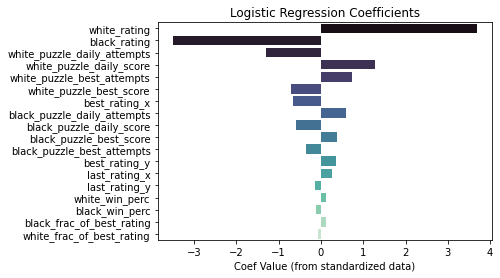

In [1075]:
#coef importance graph
feature_df = pd.DataFrame(logreg.coef_.T,index=X.columns)
feature_df['abs'] = np.abs(feature_df[0])
feature_df = feature_df.sort_values(by='abs', ascending=False)
sns.barplot(x = feature_df.head(18)[0],y = feature_df.head(18).index, orient='h',palette="mako");
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coef Value (from standardized data)')

In [1076]:
#print out single prediction example
row_n = 8

row = X_test_scaled[row_n]
index = X_test.iloc[[row_n],:].index.values[0]

X_ex = final_df.loc[index,mask]
y_ex = final_df.loc[index,'white_result']

print('White Player: ',final_df.loc[index,'white_name'])
print('Black Player: ',final_df.loc[index,'black_name'])
print('Game: ',final_df.loc[index,'game'])
print('Time Control: ',final_df.loc[index,'time_control'])
print(X_ex)
print(y_ex)
print('The predicted outcome is: ',logreg.predict(row.reshape(1,-1))[0])
print('The predicted prob is: ',logreg.predict_proba(row.reshape(1,-1)))


White Player:  josiwales
Black Player:  Agent-JL
Game:  chess_blitz
Time Control:  180
white_rating                        2621
black_rating                        2560
last_rating_x                     2625.0
best_rating_x                     2915.0
white_puzzle_best_attempts          57.0
white_puzzle_best_score             54.0
white_puzzle_daily_attempts          0.0
white_puzzle_daily_score             0.0
last_rating_y                     2506.0
best_rating_y                     2641.0
black_puzzle_best_attempts          63.0
black_puzzle_best_score             60.0
black_puzzle_daily_attempts          0.0
black_puzzle_daily_score             0.0
white_win_perc                  0.502413
black_win_perc                  0.470546
white_days_since_best_rating         503
black_days_since_best_rating         517
white_frac_of_best_rating       0.899142
black_frac_of_best_rating        0.96933
white_frac_of_last_rating       0.900515
black_frac_of_last_rating       0.948883
Name: 16389

In [1083]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
logreg.intercept_

array([0.074463])